In [15]:
import rasterio

import numpy as np
import pandas as pd

from matplotlib import pyplot as plt 
import matplotlib as mpl
import geopandas as gpd
from shapely.geometry import Polygon, box
import matplotlib.patches as patches
import ipywidgets as widgets
from ipywidgets import interact

In [4]:
mpl.rcParams['figure.figsize']= [24.0, 16.0]

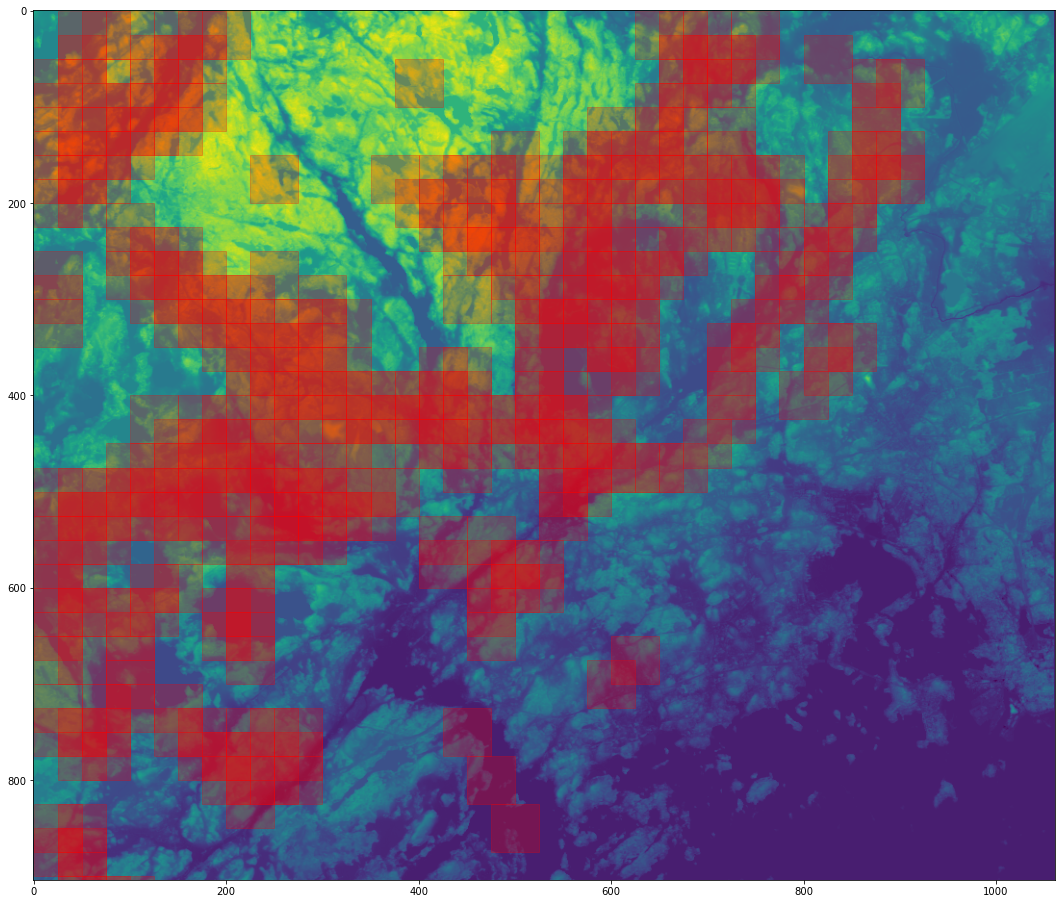

In [79]:
WINDOW_SIZE = 50
FRACTURE = .25
with rasterio.open('Espoo.tif') as src:
    image = src.read()[0]
    rows = np.arange(0, image.shape[0]-WINDOW_SIZE/2, WINDOW_SIZE/2, dtype=int)
    cols = np.arange(0, image.shape[1]-WINDOW_SIZE/2, WINDOW_SIZE/2, dtype=int)
    results = []
    for coord_row in rows:
        for coord_col in cols:
            std = np.std(image[coord_row:(coord_row+WINDOW_SIZE),coord_col : (coord_col+WINDOW_SIZE) ])
            results.append({
                'x': coord_row, 'y': coord_col, 'std': std
            })
    results_df = pd.DataFrame(results)
    results_df[['x', 'y']] = results_df[['x', 'y']].astype(int)
    results_df.sort_values('std', ascending=False, inplace=True)
    
    
    
    # Create figure and axes
    fig, ax = plt.subplots()
    ax.imshow(image)
    for _, row in results_df[:int(results_df.shape[0] * FRACTURE)].iterrows():
        # Create a Rectangle patch
        rect = patches.Rectangle((int(row.x), int(row.y)), WINDOW_SIZE, WINDOW_SIZE, linewidth=1, edgecolor='r', facecolor='r', alpha=0.25)

        # Add the patch to the Axes
        ax.add_patch(rect)


In [84]:
def cliff_seeker(window_size, fracture, image='Espoo.tif', plot=True, return_gdf=False):
    WINDOW_SIZE = window_size
    FRACTURE = fracture
    # 'Nuuksio_test.tif'
    with rasterio.open(image) as src:
        image = src.read()[0]
        rows = np.arange(0, image.shape[0]-WINDOW_SIZE/2, WINDOW_SIZE/2, dtype=int)
        cols = np.arange(0, image.shape[1]-WINDOW_SIZE/2, WINDOW_SIZE/2, dtype=int)
        results = []
        for coord_row in rows:
            for coord_col in cols:
                window = image[coord_row:(coord_row+WINDOW_SIZE)-1,coord_col : (coord_col+WINDOW_SIZE)-1 ]
                std = np.std(window)
                results.append({
                    'x': coord_row, 'y': coord_col, 'std': std, 'min_height': np.min(window), 'max_height': np.max(window)
                })
        results_df = pd.DataFrame(results)
        results_df[['x', 'y']] = results_df[['x', 'y']].astype(int)
        results_df['metric'] = results_df['std'] * (results_df['max_height'] - results_df['min_height'])
        results_df.sort_values('metric', ascending=False, inplace=True)
        # Store only fraction of all resutls
        results_df = results_df[:int(results_df.shape[0] * FRACTURE)].reset_index(drop=True)

        if plot:
            # Create figure and axes
            fig, ax = plt.subplots()
            ax.imshow(image)
            for _, row in results_df.iterrows():
                # Create a Rectangle patch
                rect = patches.Rectangle((int(row.x), int(row.y)), WINDOW_SIZE, WINDOW_SIZE, linewidth=1, edgecolor='r', facecolor='r', alpha=0.20)

                # Add the patch to the Axes
                ax.add_patch(rect)
        if return_gdf:
            results_gdf = gpd.GeoDataFrame(results_df, geometry=results_df.apply(
                lambda row: box(
                    *rasterio.transform.xy(src.transform, row.x, row.y + WINDOW_SIZE),
                    *rasterio.transform.xy(src.transform, row.x + WINDOW_SIZE, row.y)
                ),
                axis=1
            ))
            return results_gdf


In [85]:

window_size_slider = widgets.IntSlider(min=10, max=200, description='Window size:', value=WINDOW_SIZE, step=5, continuous_update=False)
fracture_slider = widgets.FloatSlider(min=.01, max=1.0, description='Variance fracture:', value=FRACTURE, step=.01, continuous_update=False)

interact(cliff_seeker, window_size=window_size_slider, fracture=fracture_slider)

interactive(children=(IntSlider(value=50, continuous_update=False, description='Window size:', max=200, min=10…

<function __main__.cliff_seeker(window_size, fracture, image='Espoo.tif', plot=True, return_gdf=False)>

In [86]:
cliff_seeker(15, .20, plot=False, return_gdf=True).to_file('Espoo_cliffs_15.geojson', driver='GeoJSON')

In [87]:
cliff_seeker(10, .15, plot=False, return_gdf=True).to_file('Espoo_cliffs_10.geojson', driver='GeoJSON')

In [88]:
cliff_seeker(25, .20, plot=False, return_gdf=True).to_file('Espoo_cliffs_25.geojson', driver='GeoJSON')


In [89]:
cliff_seeker(15, .10, plot=False, return_gdf=True, image='Finland_DEM.tif').to_file('Uusima_cliffs_15.geojson', driver='GeoJSON')